# EDA and Classification Notebook

This notebook:

- Generates a synthetic dataset
- Performs Exploratory Data Analysis (EDA)
- Trains a classification model (Logistic Regression or Random Forest)
- Evaluates performance with metrics and plots


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

np.random.seed(42)


In [2]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 500

df = pd.DataFrame({
    "id": range(1, n + 1),
    "age": np.random.randint(18, 70, n),
    "income": np.random.randint(20000, 120000, n),
    "gender": np.random.choice(["Male", "Female"], n),
    "region": np.random.choice(["North", "South", "East", "West"], n),
    "purchases": np.random.poisson(5, n),
    "churn": np.random.choice([0, 1], n, p=[0.7, 0.3])
})

# Introduce missing values
for col in ["age", "income", "gender", "region"]:
    df.loc[df.sample(frac=0.1).index, col] = np.nan  # 10% missing

df.to_csv("sample_classification_data.csv", index=False)
print("Dataset saved as sample_classification_data.csv")

df.head()




Dataset saved as sample_classification_data.csv


,id,age,income,gender,region,purchases,churn
0,1,56.0,23343.0,Male,North,12,1
1,2,69.0,33500.0,Male,South,3,0
2,3,46.0,NaN,Female,East,6,0
3,4,32.0,49375.0,Male,NaN,8,0
4,5,NaN,29662.0,Female,West,8,0


In [3]:
# Basic EDA
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isna().sum())



Shape: (500, 7)

Data Types:
 id             int64
age          float64
income       float64
gender        object
region        object
purchases      int64
churn          int64
dtype: object

Missing Values:
 id            0
age          50
income       50
gender       50
region       50
purchases     0
churn         0
dtype: int64


In [4]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Load dataset
df = pd.read_csv("sample_classification_data.csv")

# Separate features and target
X = df.drop(columns=["id", "churn"])
y = df["churn"]

# Numeric columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
print(num_cols)
# Categorical columns
cat_cols = X.select_dtypes(include=["object"]).columns
print(cat_cols)
# Imputation
num_imputer = SimpleImputer(strategy="median")  # replace numeric NaN with median
cat_imputer = SimpleImputer(strategy="most_frequent")  # replace categorical NaN with mode

X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

print("Missing values after imputation:\n", X.isna().sum())
X.head()


Index(['age', 'income', 'purchases'], dtype='object')
Index(['gender', 'region'], dtype='object')
Missing values after imputation:
 age          0
income       0
gender       0
region       0
purchases    0
dtype: int64


,age,income,gender,region,purchases
0,56.0,23343.0,Male,North,12.0
1,69.0,33500.0,Male,South,3.0
2,46.0,65907.0,Female,East,6.0
3,32.0,49375.0,Male,North,8.0
4,45.0,29662.0,Female,West,8.0



Target Balance (churn):
 churn
0    0.736
1    0.264
Name: proportion, dtype: float64


,id,age,income,purchases,churn
count,500.000000,450.000000,450.000000,500.000000,500.000000
mean,250.500000,43.875556,68029.757778,4.982000,0.264000
std,144.481833,15.009205,28777.814045,2.335934,0.441241
min,1.000000,18.000000,20055.000000,0.000000,0.000000
25%,125.750000,32.000000,43297.000000,3.000000,0.000000
50%,250.500000,45.000000,65907.000000,5.000000,0.000000
75%,375.250000,56.000000,92447.750000,6.250000,1.000000
max,500.000000,69.000000,119835.000000,12.000000,1.000000


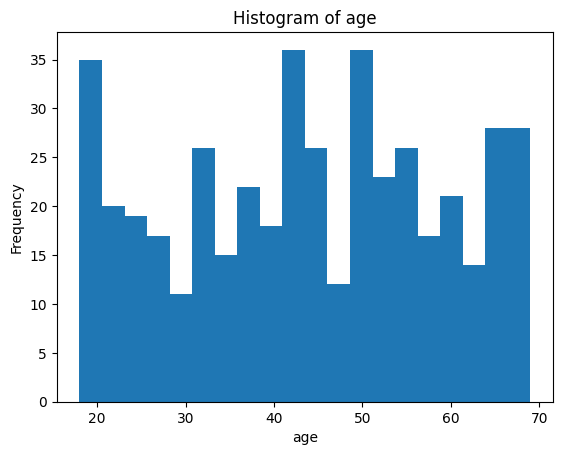

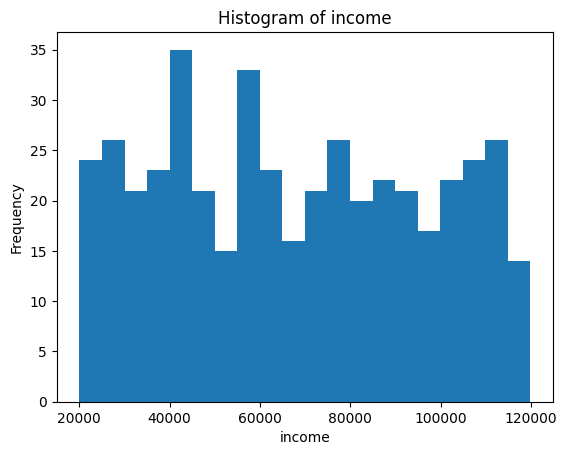

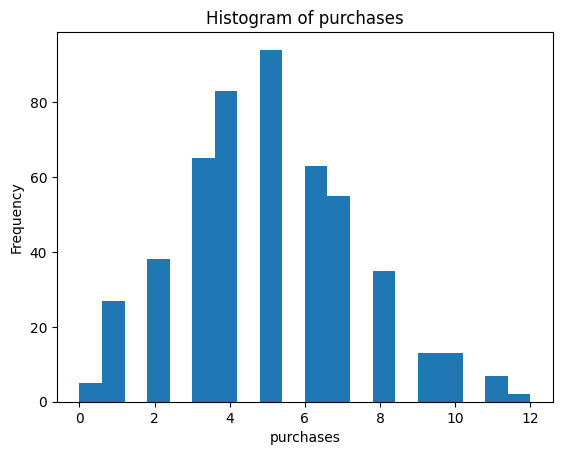

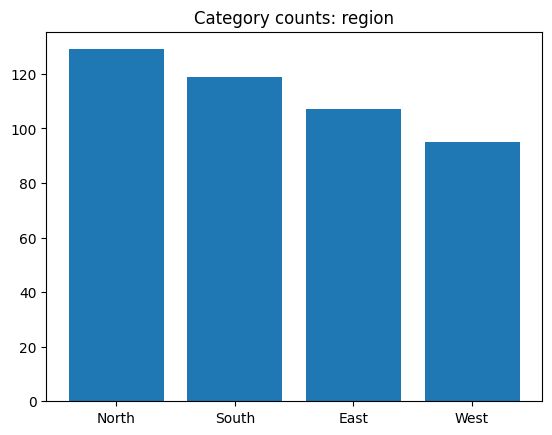

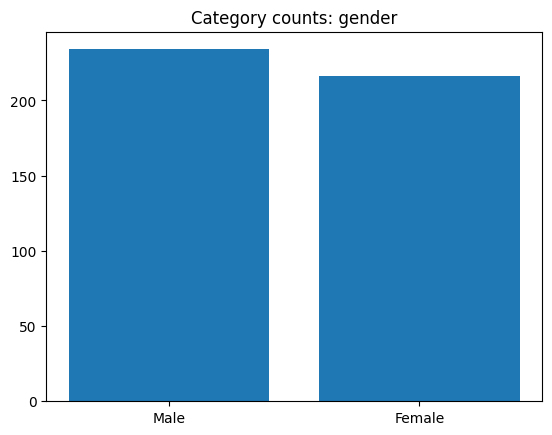

In [5]:

print("\nTarget Balance (churn):\n", df["churn"].value_counts(normalize=True))

# Numeric summary
display(df.describe())

# Histograms
numeric_cols = ["age", "income", "purchases"]
for col in numeric_cols:
    plt.hist(df[col], bins=20)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Bar plot for categorical
cat_cols = ["region", "gender"]
for col in cat_cols:
    counts = df[col].value_counts()
    plt.bar(counts.index, counts.values)
    plt.title(f"Category counts: {col}")
    plt.show()


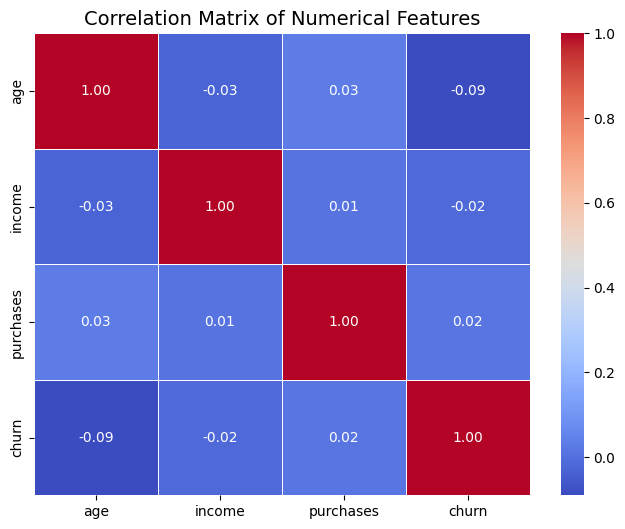

In [10]:
import seaborn as sns
# Compute correlation matrix
num_df = df.select_dtypes(include=["int64", "float64"]).drop(columns=["id"], errors="ignore")

corr_matrix = num_df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features", fontsize=14)
plt.show()

In [ ]:
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    return outliers

for col in num_cols:
    outliers = detect_outliers(df, col)
    print(f"Outliers in {col}: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    if not outliers.empty:
        print(outliers[[col, 'churn']])  # Inspect with target

Outliers in age: 0 (0.00%)
Outliers in income: 0 (0.00%)
Outliers in purchases: 2 (0.40%)
     purchases  churn
0           12      1
274         12      0


CV Scores: [0.6875 0.675  0.725  0.6875 0.75  ]
Mean CV Accuracy: 0.705

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.86      0.80        74
           1       0.29      0.15      0.20        26

    accuracy                           0.68       100
   macro avg       0.51      0.51      0.50       100
weighted avg       0.62      0.68      0.64       100

F1 Score: 0.5


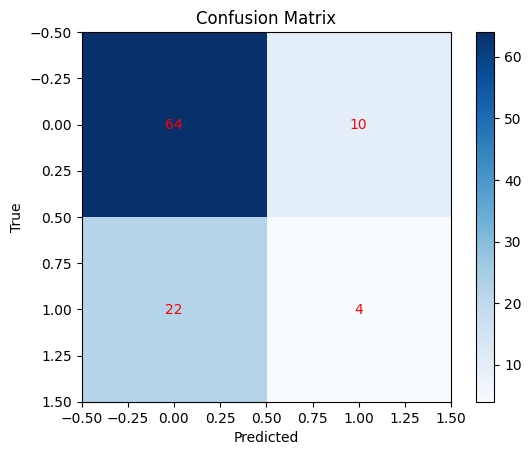

In [7]:
# Features/target
X = df.drop(columns=["churn", "id"])
y = df["churn"]

numeric_features = ["age", "income", "purchases"]
categorical_features = ["gender", "region"]

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Choose model
model = RandomForestClassifier(n_estimators=200, random_state=42)
pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average="macro"))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha="center", va="center", color="red")
plt.colorbar()
plt.show()


Accuracy: 0.66

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77        74
           1       0.35      0.35      0.35        26

    accuracy                           0.66       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.66      0.66      0.66       100



/Users/206793281/Documents/ab/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:33:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


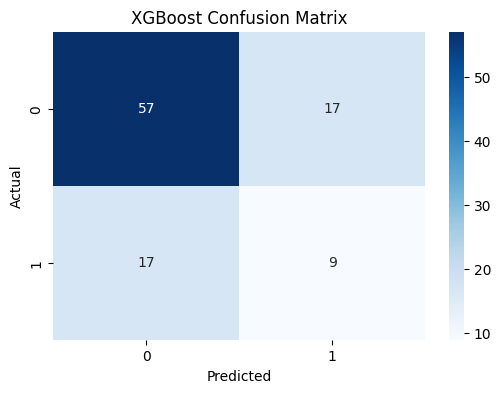

<Figure size 800x600 with 0 Axes>

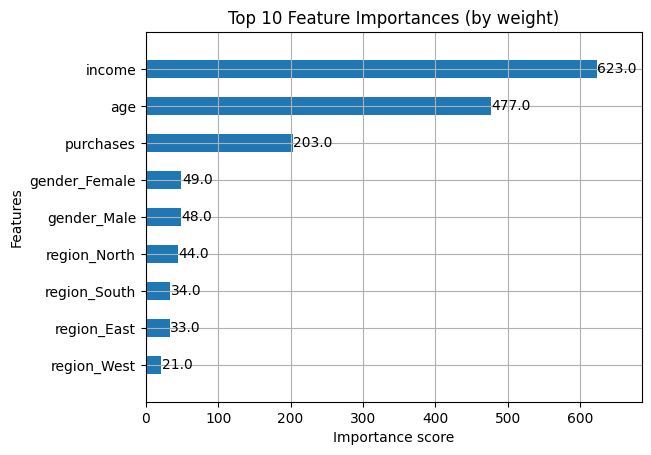

In [8]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# One-hot encode categorical features
X_train_enc = pd.get_dummies(X_train)
X_test_enc = pd.get_dummies(X_test)

# Align columns (handles cases where test has unseen categories)
X_train_enc, X_test_enc = X_train_enc.align(
    X_test_enc, join="left", axis=1, fill_value=0
)

# Train XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42
)
xgb_model.fit(X_train_enc, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_enc)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance
plt.figure(figsize=(8, 6))
plot_importance(xgb_model, importance_type="weight", max_num_features=10, height=0.5)
plt.title("Top 10 Feature Importances (by weight)")
plt.show()
